In [1]:
from discover_lora_diffusion.models import LoraDiffusion
import diffusers
import torch
from tqdm import tqdm 

from common.utils import make_weight_vector, recover_lora, convert_to_multi, rand_merge_layerwise

lora_bundle = torch.load('/home/ubuntu/AutoLoRADiscovery/lora_bundle.pt')

_, weight_dict = make_weight_vector(lora_bundle[0])

lora_diffusion = LoraDiffusion(
    data_dim=1_365_504, 
    model_dim=256, 
    ff_mult=3, 
    chunks=1, 
    act=torch.nn.SiLU, 
    num_blocks=4, 
    layers_per_block=3
)

scheduler = diffusers.UnCLIPScheduler.from_config("kandinsky-community/kandinsky-2-2-prior", subfolder="scheduler")
state_dict = torch.load('/home/ubuntu/AutoLoRADiscovery/discover_lora_diffusion/diffusion_lora/checkpoint-80000')
lora_diffusion.load_state_dict(state_dict)
lora_diffusion = lora_diffusion.cuda().to(torch.float16)


/home/ubuntu/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/miniconda3/lib/python3.11/site-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_unclip.UnCLIPScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/home/ubuntu/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when poss

In [2]:
import diffusers
from common.loras import patch_lora

pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe.safety_checker=None

lora_layers = [
        "attn2.to_q", 
        "attn2.to_k", 
        "attn2.to_v", 
        "attn2.to_out",
        # "proj_in",
        # "proj_out",
        # "norm",
        #  "ff", 
]
lora_layers_te = [
    "final_layer_norm",
    "7",
    "8",
    "9",
    "10",
    "11"
]

patch_lora(pipe.unet, rank=8, included_terms=lora_layers)
patch_lora(pipe.text_encoder, rank=8, included_terms=lora_layers_te)
pipe.scheduler = diffusers.EulerDiscreteScheduler.from_config(pipe.scheduler.config)


/home/ubuntu/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.38it/s]


In [456]:
latents = torch.randn(1, 1_365_504).cuda().to(torch.float16)
scheduler.set_timesteps(200)

with torch.no_grad():
    for t in tqdm(scheduler.timesteps):
        pred = lora_diffusion(latents, t=t.unsqueeze(0).cuda().half())
        latents = scheduler.step(pred, t, latents, return_dict=False)[0]

latents = latents * 0.0152

state_dict = recover_lora(latents, weight_dict)
state_dict = convert_to_multi(state_dict, idx=0)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 114.31it/s]


In [457]:
missing, unexpected = pipe.unet.load_state_dict(state_dict, strict=False)
missing, unexpected = pipe.text_encoder.load_state_dict(state_dict, strict=False)
pipe = pipe.to("cuda", torch.float16)

In [470]:
images = pipe("a photo of a sks person", height=640, width=640, num_inference_steps=30).images

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:01<00:00, 17.59it/s]


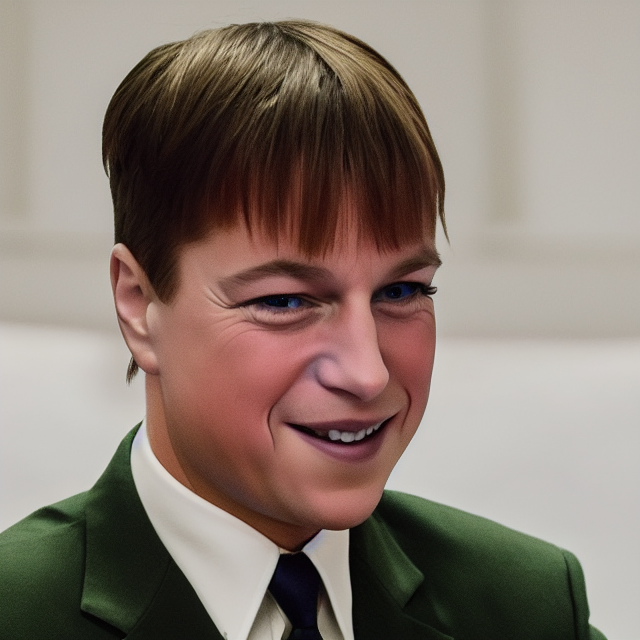

In [471]:
images[0]

In [510]:
images = pipe("art of a sks person by greg rutowski", height=640, width=640, num_inference_steps=30).images

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:01<00:00, 16.67it/s]


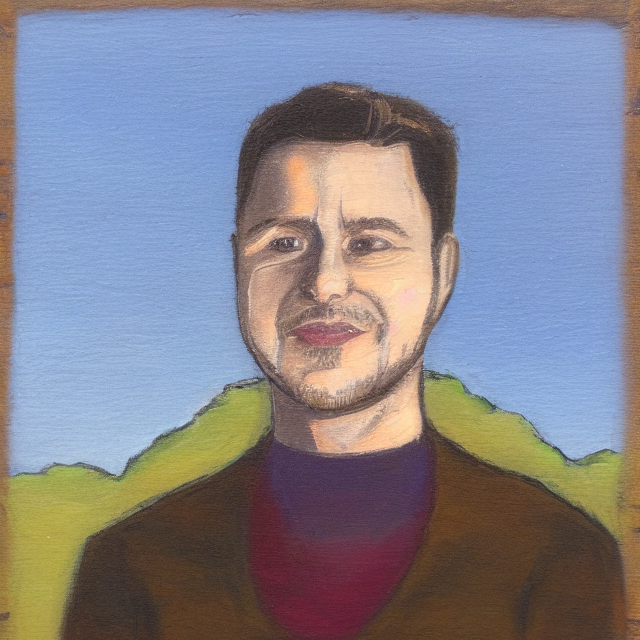

In [511]:
images[0]